In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import  datasets, transforms, models
import os
import copy

In [4]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load Datasets

In [5]:

data_dir = "Potato"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Train', 'Valid', 'Test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['Train', 'Valid', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid', 'Test']}
class_names = image_datasets['Train'].classes 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Set Up the Model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

f:\code\deep learning, potato classificatoin model\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\code\deep learning, potato classificatoin model\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# for param in model_ft.parameters():
#     param.requires_grad = False

In [8]:
# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model


In [9]:
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------


f:\code\deep learning, potato classificatoin model\venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Train Loss: 0.7719 Acc: 0.7033
Valid Loss: 0.2890 Acc: 0.9167
Epoch 1/24
----------
Train Loss: 0.2368 Acc: 0.9356
Valid Loss: 0.0989 Acc: 0.9800
Epoch 2/24
----------
Train Loss: 0.1113 Acc: 0.9700
Valid Loss: 0.0548 Acc: 0.9900
Epoch 3/24
----------
Train Loss: 0.0905 Acc: 0.9711
Valid Loss: 0.0567 Acc: 0.9900
Epoch 4/24
----------
Train Loss: 0.0810 Acc: 0.9744
Valid Loss: 0.0506 Acc: 0.9900
Epoch 5/24
----------
Train Loss: 0.0810 Acc: 0.9733
Valid Loss: 0.0313 Acc: 0.9967
Epoch 6/24
----------
Train Loss: 0.0605 Acc: 0.9789
Valid Loss: 0.0439 Acc: 0.9900
Epoch 7/24
----------
Train Loss: 0.0575 Acc: 0.9822
Valid Loss: 0.0248 Acc: 0.9933
Epoch 8/24
----------
Train Loss: 0.0661 Acc: 0.9778
Valid Loss: 0.0165 Acc: 1.0000
Epoch 9/24
----------
Train Loss: 0.0586 Acc: 0.9833
Valid Loss: 0.0854 Acc: 0.9767
Epoch 10/24
----------
Train Loss: 0.0760 Acc: 0.9711
Valid Loss: 0.0362 Acc: 0.9900
Epoch 11/24
----------
Train Loss: 0.0677 Acc: 0.9744
Valid Loss: 0.0291 Acc: 0.9967
Epoch 12/24


In [10]:
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    print('Test Accuracy: {:.4f}'.format(acc))


In [11]:
# Evaluate the model on the test set
evaluate_model(model_ft, dataloaders['Test'])


Test Accuracy: 1.0000


In [12]:
# Save the trained model
torch.save(model_ft.state_dict(), 'potato_leaf_model.pth')


In [14]:
!pip install matplotlib

     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     -------------------------------------  163.8/165.5 kB 9.6 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------- ----------------- 4.4/8.0 MB 93.7 MB/s eta 0:00:01
   ---------------------------------------  8.0/8.0 MB 102.0 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 73.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/189.9 kB ? eta -:--:--
   --------------------------------------- 189.9/189.9 kB 11.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------  2.2/2.2 MB 136.3 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 35.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/56.0 kB ? eta -:--:--
   ------------------

In [15]:
import matplotlib.pyplot as plt

def train_model_with_visualization(model, criterion, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'Train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                valid_loss_history.append(epoch_loss)
                valid_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)

    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(valid_acc_history, label='Valid Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

model_ft = train_model_with_visualization(model_ft, criterion, optimizer, num_epochs=25)


Epoch 0/24
----------
Train Loss: 0.0534 Acc: 0.9833
Valid Loss: 0.0298 Acc: 0.9933
Epoch 1/24
----------
Train Loss: 0.0533 Acc: 0.9822
Valid Loss: 0.0307 Acc: 0.9933
Epoch 2/24
----------
Train Loss: 0.0339 Acc: 0.9922
Valid Loss: 0.0223 Acc: 0.9967
Epoch 3/24
----------
Train Loss: 0.0277 Acc: 0.9944
Valid Loss: 0.0201 Acc: 0.9967
Epoch 4/24
----------
Train Loss: 0.0439 Acc: 0.9856
Valid Loss: 0.0223 Acc: 0.9933
Epoch 5/24
----------
Train Loss: 0.0440 Acc: 0.9844
Valid Loss: 0.0339 Acc: 0.9933
Epoch 6/24
----------
Train Loss: 0.0373 Acc: 0.9889
Valid Loss: 0.0232 Acc: 0.9967
Epoch 7/24
----------
Train Loss: 0.0500 Acc: 0.9833
Valid Loss: 0.0183 Acc: 0.9967
Epoch 8/24
----------
Train Loss: 0.0405 Acc: 0.9900
Valid Loss: 0.0192 Acc: 1.0000
Epoch 9/24
----------


KeyboardInterrupt: 

In [16]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import os


In [17]:
# Load the saved model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # Assuming 3 classes: Early_blight, Healthy, Late_blight
model.load_state_dict(torch.load('potato_leaf_model.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()


f:\code\deep learning, potato classificatoin model\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\code\deep learning, potato classificatoin model\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Define the preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


In [19]:
# Define the prediction function
def predict(image_path, model, class_names):
    image = preprocess_image(image_path)
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    predicted_class = class_names[preds[0]]
    return predicted_class


Predicted class: Potato___Early_blight


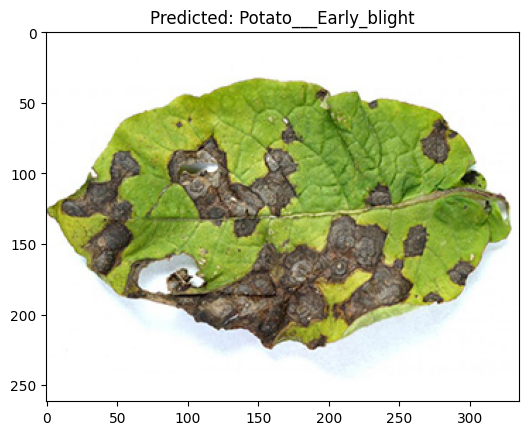

In [21]:
# Define class names (should match the order in your dataset)
class_names = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

# Predict the class of a new image
image_path = 'Alternaria Leaf resized.jpg'  # Replace with the path to your image
predicted_class = predict(image_path, model, class_names)

print(f'Predicted class: {predicted_class}')

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted: {predicted_class}')
plt.show()
